## Initialization

In [10]:
# import pandas as pd
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas import Series,DataFrame
import numpy as np
import os
# import talib as tb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import scipy.optimize as sco

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
import pandas_datareader.data as web
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [11]:
class YahooDailyReader():
    
    def __init__(self, symbol=None, start=None, end=None):
        import datetime, time
        self.symbol = symbol
        
        # initialize start/end dates if not provided
        if end is None:
            end = datetime.datetime.today()
        if start is None:
            start = datetime.datetime(2015,1,1)
        
        self.start = start
        self.end = end
        
        # convert dates to unix time strings
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))
        
        url = 'https://finance.yahoo.com/quote/{}/history?'
        url += 'period1={}&period2={}'
        url += '&filter=history'
        url += '&interval=1d'
        url += '&frequency=1d'
        self.url = url.format(self.symbol, unix_start, unix_end)
        
#         url = 'https://finance.yahoo.com/quote/{}/key-statistics?'
#         url += 'period1={}&period2={}'
#         url += '&filter=history'
#         url += '&interval=1d'
#         url += '&frequency=1d'
#         self.url_2 = url.format(self.symbol, unix_start, unix_end)
        
    def read(self):
        import requests, re, json
       
        r = requests.get(self.url)
#         q = requests.get(self.url_2)
        
        ptrn = r'root\.App\.main = (.*?);\n}\(this\)\);'
        txt = re.search(ptrn, r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        df = pd.DataFrame(
                jsn['context']['dispatcher']['stores']
                ['HistoricalPriceStore']['prices']
                )
#         df.insert(0, 'symbol', self.symbol)
        df['date'] = pd.to_datetime(df['date'], unit='s').dt.date
        
        # drop rows that aren't prices
        df = df.dropna(subset=['close'])
        
        df = df[['date', 'high', 'low', 'open', 'close', 
                 'volume', 'adjclose']]
#         df = df.set_index('symbol')
        return df



In [12]:
#Helper functions

def ANN_log_return(adjclose,d):
    return np.log(adjclose/adjclose.shift(d))

def expected_return(adjclose,d):
    return np.mean(np.log(adjclose/adjclose.shift(d)))

def vol(returns):
# Return the standard deviation of returns
    return np.std(returns)

def beta(returns, market):
# Create a matrix of [returns, market]
    m = np.matrix([returns, market])
# Return the covariance of m divided by the standard deviation of the market returns
    return np.cov(m)[0][1] / np.std(market)

def var(returns, alpha):
    # This method calculates the historical simulation var of the returns
    sorted_returns = np.sort(returns)
    # Calculate the index associated with alpha
    index = int(alpha * len(sorted_returns))
    # VaR should be positive
    return abs(sorted_returns[index])
 
def cvar(returns, alpha):
    # This method calculates the condition VaR of the returns
    sorted_returns = np.sort(returns)
    # Calculate the index associated with alpha
    index = int(alpha * len(sorted_returns))
    # Calculate the total VaR beyond alpha
    sum_var = sorted_returns[0]
    for i in range(1, index):
        sum_var += sorted_returns[i]
    # Return the average VaR
    # CVaR should be positive
    return abs(sum_var / index)


def treynor_ratio(er, returns, market, rf):
    return (er - rf) / beta(returns, market)


# def sharpe_ratio(adjclose, rf, d):
#     return expected_return(adjclose,d) - rf / (vol(daily_log_return(adjclose)))


def information_ratio(returns, benchmark):
    diff = returns - benchmark
    return np.mean(diff) / vol(diff)


## Hyperparameters

In [13]:
rf = 0.0243875
d = 252

## Data Preparation

In [14]:
import csv

StockList = pd.read_csv("StockList.csv") 
StockList["Symbol"][1]
StockList["Name"][1]

StockDict = {}
Analysis = StockList
Analysis["Expected_return"] = 0.0
Analysis["Volatility"] = 0.0
Analysis["Sharpe_Ratio"] = 0.0



In [15]:
for i in range(0,len(StockList)):   
    ydr = YahooDailyReader(StockList["Symbol"][i])
    StockDict[StockList["Name"][i]] = ydr.read()
    StockDict[StockList["Name"][i]] = StockDict[StockList["Name"][i]].sort_values('date')
    StockDict[StockList["Name"][i]] = StockDict[StockList["Name"][i]].reset_index(drop=True)
    StockDict[StockList["Name"][i]]["%_Return"] = StockDict[StockList["Name"][i]]["adjclose"].pct_change()

In [16]:
for i in range(0,len(StockList)): 
    Analysis["Expected_return"][i] = expected_return(StockDict[StockList["Name"][i]]["adjclose"], d)
    Analysis["Volatility"][i] =  (vol(ANN_log_return(StockDict[StockList["Name"][i]]["adjclose"], d)))
    Analysis["Sharpe_Ratio"][i] = (Analysis["Expected_return"][i]-rf)/Analysis["Volatility"][i]

In [17]:
Analysis.sort_values("Sharpe_Ratio", ascending = False)

,Symbol,Name,Expected_return,Volatility,Sharpe_Ratio
42,2313.HK,SHENZHOU_INTL,0.320981,0.160967,1.842577
23,0823.HK,LINK_REIT,0.191935,0.110449,1.516963
1,0002.HK,CLP_HOLDINGS,0.128427,0.073103,1.423196
45,2382.HK,SUNNY_OPTICAL,0.628871,0.529919,1.140711
40,2007.HK,COUNTRY_GARDEN,0.500642,0.513460,0.927540
21,0700.HK,TENCENT,0.293972,0.300036,0.898505
32,1093.HK,CSPC_PHARMA,0.309128,0.320263,0.889083
2,0003.HK,HK_&_CHINA_GAS,0.113786,0.106950,0.835887
5,0011.HK,HANG_SENG_BANK,0.134647,0.137220,0.803522
15,0175.HK,GEELY_AUTO,0.518058,0.647081,0.762919


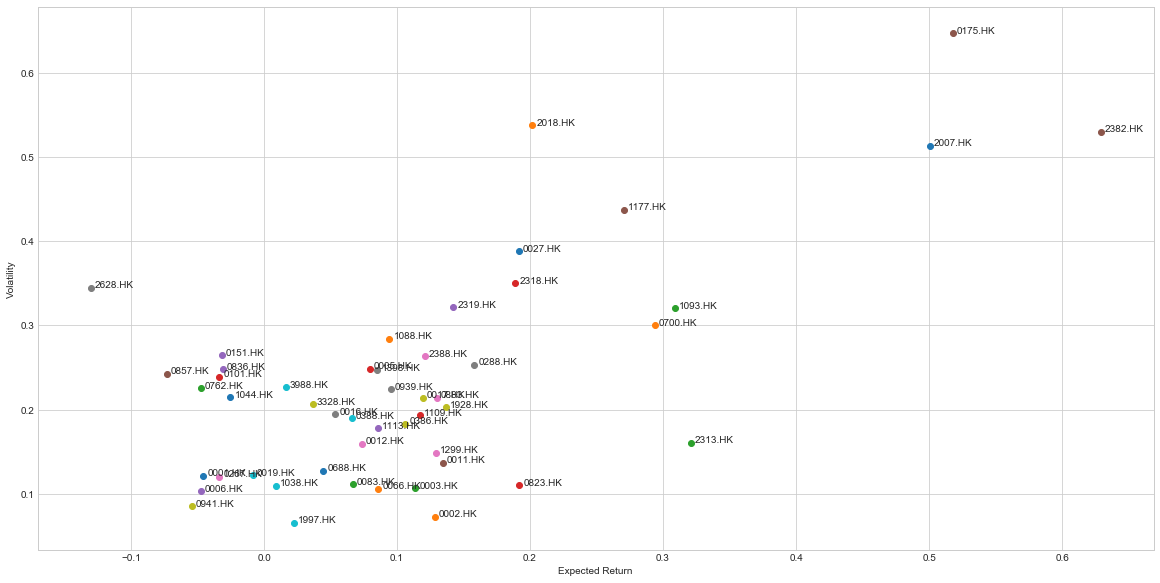

In [18]:
plt.figure(figsize=(20,10))

for i,type in enumerate(Analysis['Symbol']):
    x = Analysis['Expected_return'][i]
    y = Analysis['Volatility'][i]
    plt.scatter(x, y)
    plt.text(x + 0.003, y, type, fontsize = 10)
    
plt.xlabel('Expected Return')
plt.ylabel('Volatility')
plt.show()

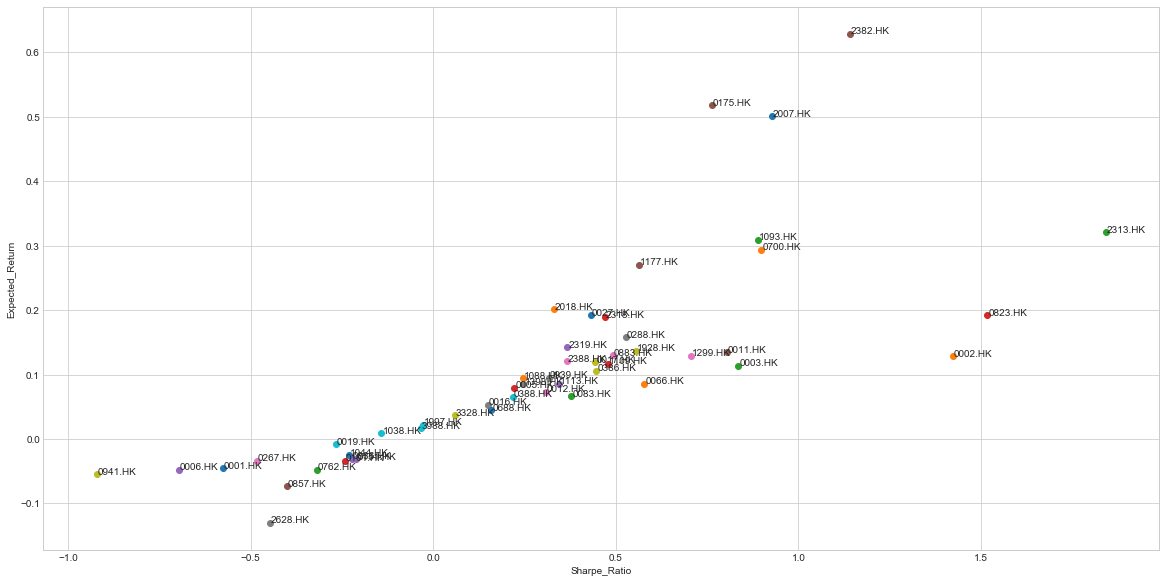

In [19]:
plt.figure(figsize=(20,10))

for i,type in enumerate(Analysis['Symbol']):
    x = Analysis['Sharpe_Ratio'][i]
    y = Analysis['Expected_return'][i]
    plt.scatter(x, y)
    plt.text(x + 0.003, y, type, fontsize = 10)
    
plt.xlabel('Sharpe_Ratio')
plt.ylabel('Expected_Return')
plt.show()

In [20]:
n_clusters = 5

In [21]:
from sklearn import cluster, datasets, metrics

kmeans_fit = cluster.KMeans(n_clusters).fit(Analysis.iloc[:,2:])
Analysis["Risk_Group"] = kmeans_fit.labels_


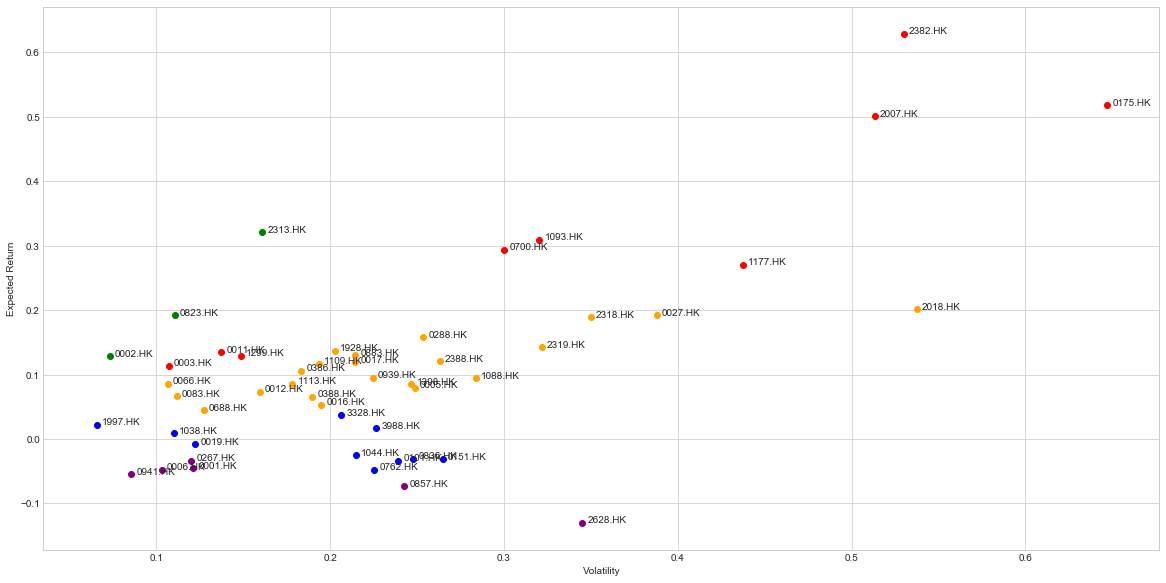

In [22]:
color_label = ['red','blue','green','purple','orange']
plt.figure(figsize=(20,10))

for i,type in enumerate(Analysis['Symbol']):
    x = Analysis['Volatility'][i]
    y = Analysis['Expected_return'][i]
    for j in range(n_clusters):
        if Analysis["Risk_Group"][i] == j:
            plt.scatter(x, y, c = color_label[j])
            plt.text(x + 0.003, y, type, fontsize = 10 )
    
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.show()

In [23]:
portfolio_asset = Analysis.sort_values("Sharpe_Ratio", ascending = False).take([0,1,2,3,4,5,6,7])
portfolio_asset

,Symbol,Name,Expected_return,Volatility,Sharpe_Ratio,Risk_Group
42,2313.HK,SHENZHOU_INTL,0.320981,0.160967,1.842577,2
23,0823.HK,LINK_REIT,0.191935,0.110449,1.516963,2
1,0002.HK,CLP_HOLDINGS,0.128427,0.073103,1.423196,2
45,2382.HK,SUNNY_OPTICAL,0.628871,0.529919,1.140711,0
40,2007.HK,COUNTRY_GARDEN,0.500642,0.513460,0.927540,0
21,0700.HK,TENCENT,0.293972,0.300036,0.898505,0
32,1093.HK,CSPC_PHARMA,0.309128,0.320263,0.889083,0
2,0003.HK,HK_&_CHINA_GAS,0.113786,0.106950,0.835887,0


## Portfolio Optimisation

### Helper functions

In [24]:

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(8)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

### Full HSI

In [52]:
table_full_HSI = pd.DataFrame()
table_full_HSI['Date'] = StockDict[StockList["Name"][1]]['date']
for i in range(0,len(StockList)): 
    table_full_HSI[StockList['Name'][i]] = StockDict[StockList["Name"][i]]['adjclose']
table_full_HSI = table_full_HSI.set_index('Date')

## Correlation
corr = table_full_HSI.corr()
corr.style.background_gradient()

In [53]:
returns = table_full_HSI.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000

#### Portfolio construction

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.32
Annualised Volatility: 0.17


            CKH_HOLDINGS  CLP_HOLDINGS  HK_&_CHINA_GAS  HSBC_HOLDINGS  \
allocation           0.0          18.0             0.0            0.0   

            POWER_ASSETS  HANG_SENG_BANK  HENDERSON_LAND  SHK_PPT  \
allocation           0.0             0.0             0.0      0.0   

            NEW_WORLD_DEV  SWIRE_PACIFIC_A      ...        COUNTRY_GARDEN  \
allocation            0.0              0.0      ...                  9.45   

            AAC_TECH  SHENZHOU_INTL  PING_AN  MENGNIU_DAIRY  SUNNY_OPTICAL  \
allocation       0.0          20.69      0.0            0.0          10.44   

            BOC_HONG_KONG  CHINA_LIFE  BANKCOMM  BANK_OF_CHINA  
allocation            0.0         0.0       0.0            0.0  

[1 rows x 50 columns]
-----------------------------------------------------------------------

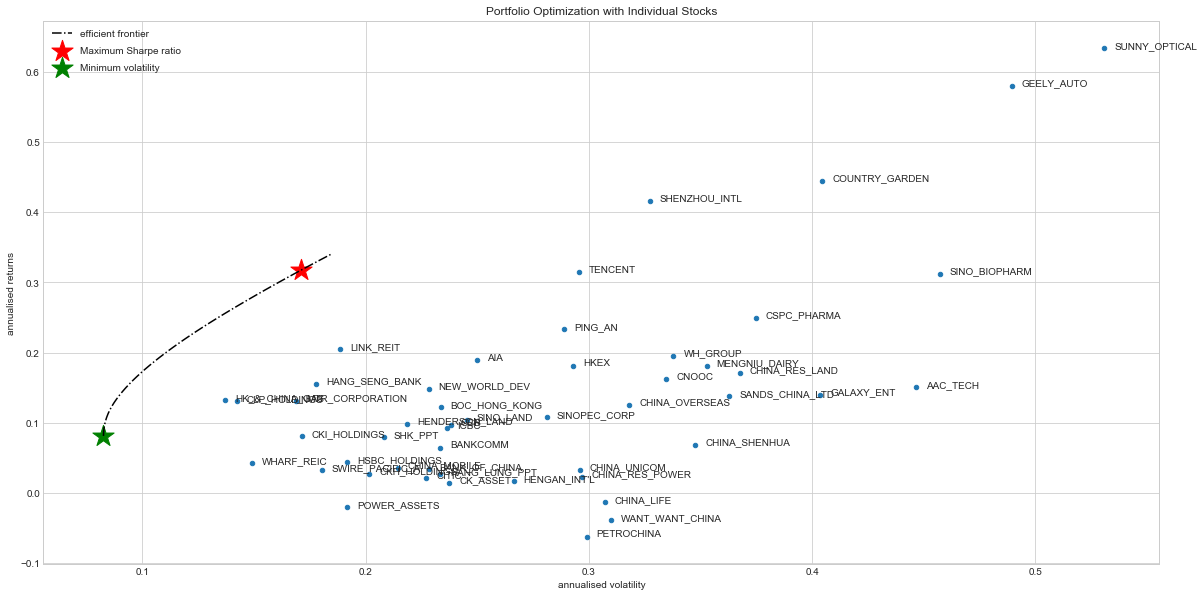

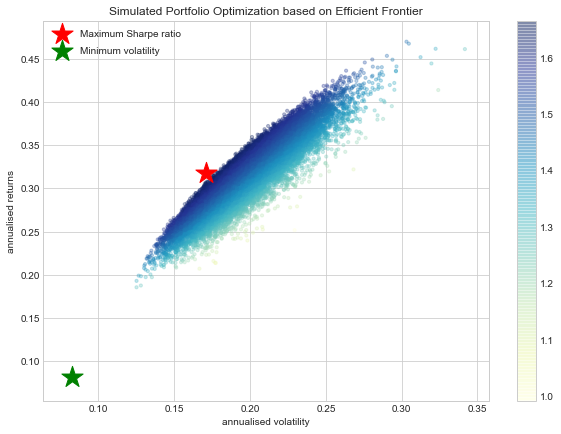

In [54]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, rf)
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table_full_HSI.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T
max_sharpe_allocation

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table_full_HSI.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns) * np.sqrt(252)
an_rt = mean_returns * 252

print ("-"*80)
print ("Maximum Sharpe Ratio Portfolio Allocation\n")
print ("Annualised Return:", round(rp,2))
print ("Annualised Volatility:", round(sdp,2))
print ("\n")
print (max_sharpe_allocation)
print ("-"*80)
print ("Minimum Volatility Portfolio Allocation\n")
print ("Annualised Return:", round(rp_min,2))
print ("Annualised Volatility:", round(sdp_min,2))
print ("\n")
print (min_vol_allocation)
print ("-"*80)
print ("Individual Stock Returns and Volatility\n")
for i, txt in enumerate(table_full_HSI.columns):
    print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
print ("-"*80)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(an_vol,an_rt,marker='o',s=20)

for i, txt in enumerate(table_full_HSI.columns):
    ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

target = np.linspace(rp_min, 0.34, 50)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
ax.set_title('Portfolio Optimization with Individual Stocks')
ax.set_xlabel('annualised volatility')
ax.set_ylabel('annualised returns')
ax.legend(labelspacing=0.8)
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar()
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend(labelspacing=0.8)
plt.show()

### 8 Assets portfolio

In [43]:
portfolio_asset

,Symbol,Name,Expected_return,Volatility,Sharpe_Ratio,Risk_Group
42,2313.HK,SHENZHOU_INTL,0.320981,0.160967,1.842577,2
23,0823.HK,LINK_REIT,0.191935,0.110449,1.516963,2
1,0002.HK,CLP_HOLDINGS,0.128427,0.073103,1.423196,2
45,2382.HK,SUNNY_OPTICAL,0.628871,0.529919,1.140711,0
40,2007.HK,COUNTRY_GARDEN,0.500642,0.513460,0.927540,0
21,0700.HK,TENCENT,0.293972,0.300036,0.898505,0
32,1093.HK,CSPC_PHARMA,0.309128,0.320263,0.889083,0
2,0003.HK,HK_&_CHINA_GAS,0.113786,0.106950,0.835887,0


In [44]:
table = pd.DataFrame()
table['Date'] = StockDict[StockList["Name"][1]]['date']
for i in range(0,len(StockList)): 
    table[StockList['Name'][i]] = StockDict[StockList["Name"][i]]['adjclose']
table = table.set_index('Date')
stock=list(portfolio_asset["Name"])
table=table[stock]

## Correlation
corr = table.corr()
corr.style.background_gradient()

,SHENZHOU_INTL,LINK_REIT,CLP_HOLDINGS,SUNNY_OPTICAL,COUNTRY_GARDEN,TENCENT,CSPC_PHARMA,HK_&_CHINA_GAS
SHENZHOU_INTL,1,0.948884,0.892445,0.820779,0.870393,0.856513,0.892695,0.942931
LINK_REIT,0.948884,1,0.94353,0.800242,0.856532,0.86205,0.815263,0.96721
CLP_HOLDINGS,0.892445,0.94353,1,0.732865,0.763147,0.771986,0.744279,0.912404
SUNNY_OPTICAL,0.820779,0.800242,0.732865,1,0.962067,0.960807,0.929016,0.769166
COUNTRY_GARDEN,0.870393,0.856532,0.763147,0.962067,1,0.980436,0.941796,0.834606
TENCENT,0.856513,0.86205,0.771986,0.960807,0.980436,1,0.909584,0.817782
CSPC_PHARMA,0.892695,0.815263,0.744279,0.929016,0.941796,0.909584,1,0.823122
HK_&_CHINA_GAS,0.942931,0.96721,0.912404,0.769166,0.834606,0.817782,0.823122,1


In [38]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000

#### Portfolio construction

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.33
Annualised Volatility: 0.18


            SHENZHOU_INTL  LINK_REIT  CLP_HOLDINGS  SUNNY_OPTICAL  \
allocation          24.09      27.58         20.28          13.46   

            COUNTRY_GARDEN  TENCENT  CSPC_PHARMA  HK_&_CHINA_GAS  
allocation            12.8      0.0          0.0            1.78  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.12


            SHENZHOU_INTL  LINK_REIT  CLP_HOLDINGS  SUNNY_OPTICAL  \
allocation           3.33      13.31         37.71            0.0   

            COUNTRY_GARDEN  TENCENT  CSPC_PHARMA  HK_&_CHINA_GAS  
allocation             0.0      0.0         4.35            41.3  
--------------------------------------------------------------------------------
Individual Stock Re

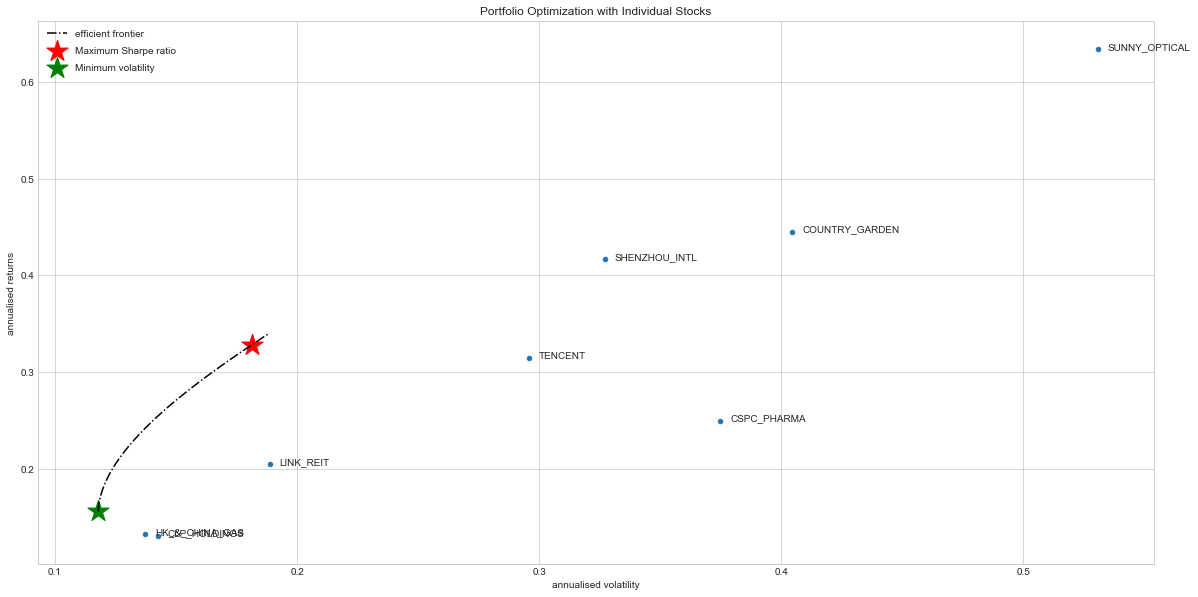

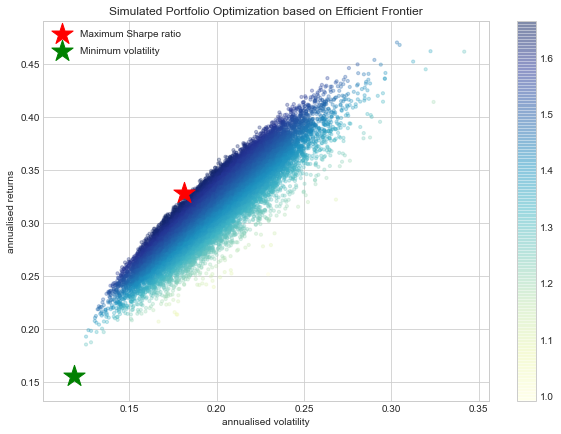

In [46]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, rf)
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T
max_sharpe_allocation

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns) * np.sqrt(252)
an_rt = mean_returns * 252

print ("-"*80)
print ("Maximum Sharpe Ratio Portfolio Allocation\n")
print ("Annualised Return:", round(rp,2))
print ("Annualised Volatility:", round(sdp,2))
print ("\n")
print (max_sharpe_allocation)
print ("-"*80)
print ("Minimum Volatility Portfolio Allocation\n")
print ("Annualised Return:", round(rp_min,2))
print ("Annualised Volatility:", round(sdp_min,2))
print ("\n")
print (min_vol_allocation)
print ("-"*80)
print ("Individual Stock Returns and Volatility\n")
for i, txt in enumerate(table.columns):
    print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
print ("-"*80)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(an_vol,an_rt,marker='o',s=20)

for i, txt in enumerate(table.columns):
    ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

target = np.linspace(rp_min, 0.34, 50)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
ax.set_title('Portfolio Optimization with Individual Stocks')
ax.set_xlabel('annualised volatility')
ax.set_ylabel('annualised returns')
ax.legend(labelspacing=0.8)
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar()
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend(labelspacing=0.8)
plt.show()

## CAL Construction

In [30]:
rp

0.32804992230379654

## Graphical Analysis

In [241]:
def Adv_Analysis(date, adjclose):
    df = pd.DataFrame()
    df['3day MA'] = adjclose.shift(1).rolling(window = 3).mean()
    df['10day MA'] = adjclose.shift(1).rolling(window = 10).mean()
    df['30day MA'] = adjclose.shift(1).rolling(window = 30).mean()
    df['Std_dev']= adjclose.rolling(5).std()
    #df['RSI'] = tb.RSI(adjclose.values, timeperiod = 9)
    
    plt.figure(figsize=(20,5))

    plt.plot(date,adjclose)
   # plt.plot(date,df['RSI'])
    plt.plot(date,df['30day MA'])
    plt.legend()
    plt.show()

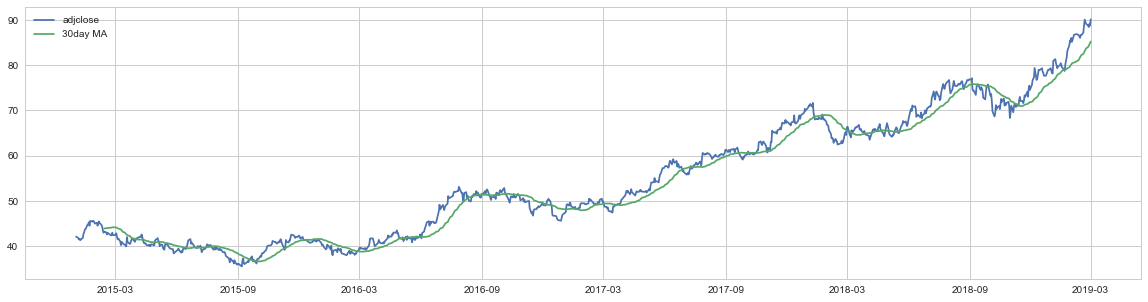

In [242]:
name = "LINK_REIT"
Adv_Analysis(StockDict[name]["date"],StockDict[name]["adjclose"])